# 06 – Model Evaluation

This notebook compares the performance of the trained models using various metrics and visualises the results with confusion matrices and ROC curves.


X_test shape: (40000, 19) sparse: True
y_test distribution:
label
0    0.9543
1    0.0457
Name: proportion, dtype: float64
X_test_dense shape: (40000, 19) dtype: float32

Final Evaluation Results:
                   Model   ROC_AUC   LogLoss    PR_AUC  BestThr_F1  \
3             Bagging_LR  0.546442  0.184862  0.056800    0.052741   
9  Bagging_LR_Calibrated  0.547645  0.184917  0.056796    0.051528   
0     LogisticRegression  0.546306  0.184884  0.056705    0.052955   
7    Voting_WeightedSoft  0.544281  0.241319  0.055548    0.167785   
6            Voting_Soft  0.544259  0.244188  0.055514    0.171889   
4   HistGradientBoosting  0.552093  0.184951  0.054692    0.050743   
8               Stacking  0.541503  0.185304  0.054063    0.049561   
5          XGBoost_Tuned  0.539574  0.650461  0.053649    0.524795   
2             ExtraTrees  0.535406  0.185486  0.051955    0.049262   
1           RandomForest  0.524178  0.188247  0.050326    0.040662   

   F1_at_best  Precision_at_best

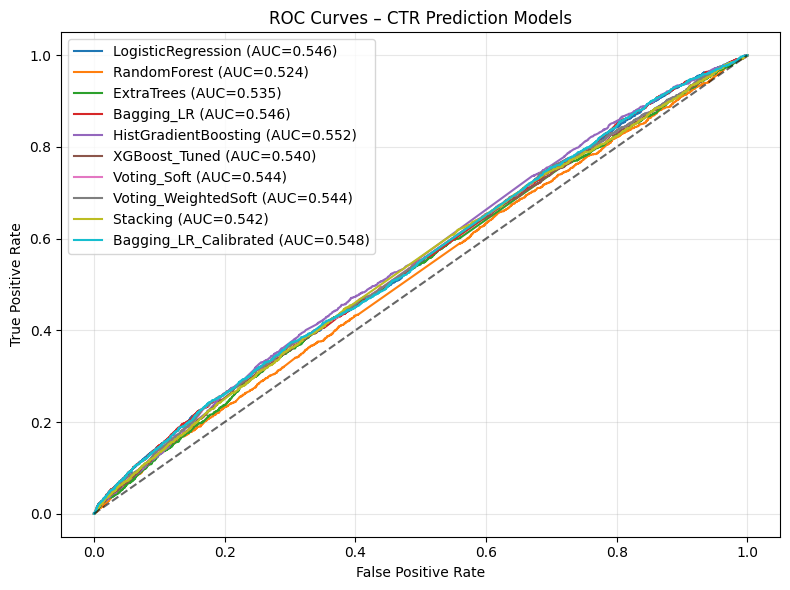

Saved figure: d:\projects\Ai\project_fusion_ecu\data\processed\figures_eval\roc_curves.png


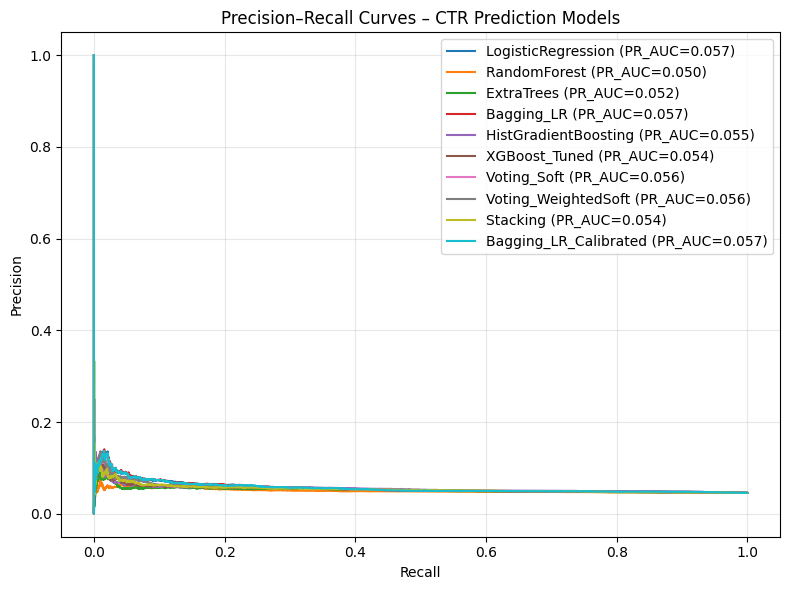

Saved figure: d:\projects\Ai\project_fusion_ecu\data\processed\figures_eval\pr_curves.png


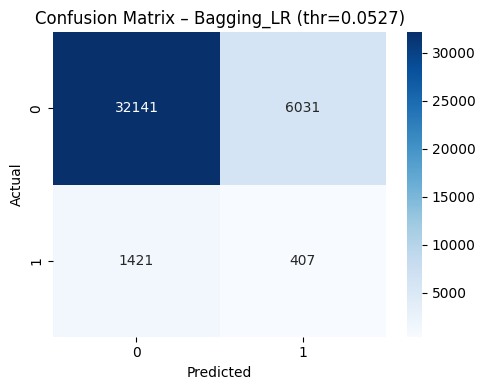

Saved figure: d:\projects\Ai\project_fusion_ecu\data\processed\figures_eval\confusion_matrix_best.png

Precision@K:
                    Model     K  Precision@K
0              Bagging_LR   500       0.1020
4   Bagging_LR_Calibrated   500       0.1000
8      LogisticRegression   500       0.0980
16            Voting_Soft   500       0.0940
12    Voting_WeightedSoft   500       0.0920
20   HistGradientBoosting   500       0.0840
28          XGBoost_Tuned   500       0.0840
24               Stacking   500       0.0820
32             ExtraTrees   500       0.0780
36           RandomForest   500       0.0540
1              Bagging_LR  1000       0.0890
5   Bagging_LR_Calibrated  1000       0.0890
9      LogisticRegression  1000       0.0890
13    Voting_WeightedSoft  1000       0.0780
17            Voting_Soft  1000       0.0780
25               Stacking  1000       0.0740
29          XGBoost_Tuned  1000       0.0730
21   HistGradientBoosting  1000       0.0680
33             ExtraTrees  10

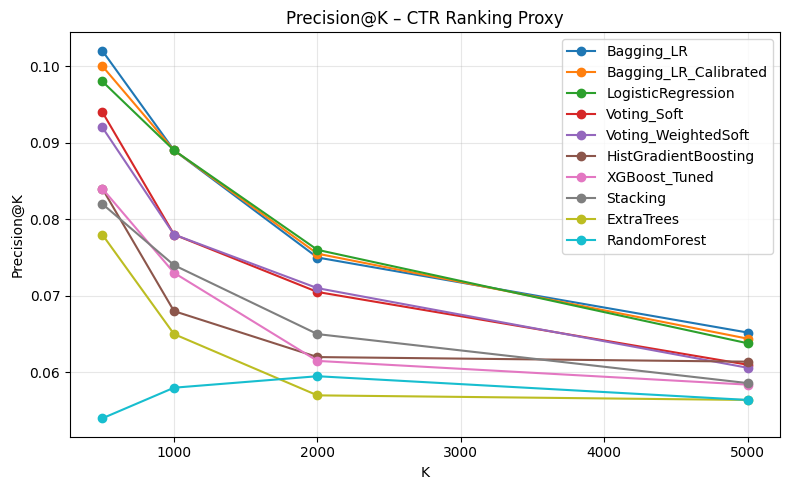

Saved figure: d:\projects\Ai\project_fusion_ecu\data\processed\figures_eval\precision_at_k.png

[Evaluation completed successfully.]


In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import load_npz, issparse
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    log_loss,
    confusion_matrix,
    precision_score,
    recall_score,
)

# ===============================
# Paths
# ===============================
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
processed_dir = os.path.join(project_root, "data", "processed")
models_dir = os.path.join(project_root, "models")
fig_dir = os.path.join(processed_dir, "figures_eval")
os.makedirs(fig_dir, exist_ok=True)

X_test_path = os.path.join(processed_dir, "X_test_processed.npz")
y_test_path = os.path.join(processed_dir, "y_test.csv")

if not os.path.exists(X_test_path):
    raise FileNotFoundError(X_test_path)
if not os.path.exists(y_test_path):
    raise FileNotFoundError(y_test_path)

# ===============================
# Load data
# ===============================
X_test = load_npz(X_test_path).tocsr()
y_test = pd.read_csv(y_test_path).squeeze().astype(int)

print("X_test shape:", X_test.shape, "sparse:", issparse(X_test))
print("y_test distribution:")
print(y_test.value_counts(normalize=True))

X_test_dense = X_test.toarray().astype(np.float32)
print("X_test_dense shape:", X_test_dense.shape, "dtype:", X_test_dense.dtype)

# ===============================
# Helpers
# ===============================
def safe_predict_proba(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        return 1.0 / (1.0 + np.exp(-scores))
    raise AttributeError(f"Model {model.__class__.__name__} has no predict_proba/decision_function.")

def best_threshold_by_f1(y_true, probas):
    precision, recall, thresholds = precision_recall_curve(y_true, probas)
    precision = precision[:-1]
    recall = recall[:-1]
    f1 = (2 * precision * recall) / (precision + recall + 1e-12)
    best_idx = int(np.nanargmax(f1))
    return float(thresholds[best_idx]), float(f1[best_idx]), float(precision[best_idx]), float(recall[best_idx])

def precision_at_k(y_true, probas, k):
    k = int(min(k, len(y_true)))
    idx = np.argsort(-probas)[:k]
    return float(y_true.iloc[idx].mean())

def try_load_model(model_path):
    try:
        return joblib.load(model_path)
    except Exception as e:
        print(f"Failed to load model: {model_path} | error: {e}")
        return None

# ===============================
# Model list (matches your new training file)
# ===============================
model_names = [
    "LogisticRegression",
    "RandomForest",
    "ExtraTrees",
    "Bagging_LR",
    "HistGradientBoosting",
    "XGBoost_Tuned",
    "Voting_Soft",
    "Voting_WeightedSoft",
    "Stacking",
    "Bagging_LR_Calibrated",
]

# Models that require dense input (and anything that contains them in ensembles)
# In practice, your Voting/Stacking contain HistGradientBoosting -> should be dense too.
dense_required = {
    "HistGradientBoosting",
    "Voting_Soft",
    "Voting_WeightedSoft",
    "Stacking",
}

# ===============================
# Evaluate models
# ===============================
results = []
roc_curves = []
pr_curves = []

for name in model_names:
    model_path = os.path.join(models_dir, f"{name}_model.pkl")
    if not os.path.exists(model_path):
        print(f"Skipping {name} (model not found)")
        continue

    model = try_load_model(model_path)
    if model is None:
        continue

    X_in = X_test_dense if name in dense_required else X_test

    probas = safe_predict_proba(model, X_in)

    auc = roc_auc_score(y_test, probas)
    pr_auc = average_precision_score(y_test, probas)
    ll = log_loss(y_test, probas)

    thr, best_f1, p_best, r_best = best_threshold_by_f1(y_test, probas)

    results.append({
        "Model": name,
        "ROC_AUC": float(auc),
        "LogLoss": float(ll),
        "PR_AUC": float(pr_auc),
        "BestThr_F1": float(thr),
        "F1_at_best": float(best_f1),
        "Precision_at_best": float(p_best),
        "Recall_at_best": float(r_best),
    })

    fpr, tpr, _ = roc_curve(y_test, probas)
    roc_curves.append((name, fpr, tpr, auc))

    precision, recall, _ = precision_recall_curve(y_test, probas)
    pr_curves.append((name, recall, precision, pr_auc))

# ===============================
# Results table
# ===============================
results_df = pd.DataFrame(results)
if results_df.empty:
    print("\nNo models were evaluated. Check models_dir and filenames.")
    raise SystemExit(0)

results_df = results_df.sort_values("PR_AUC", ascending=False)
print("\nFinal Evaluation Results:")
print(results_df)

results_csv = os.path.join(processed_dir, "final_evaluation_results.csv")
results_df.to_csv(results_csv, index=False)
print("Saved:", results_csv)

# ===============================
# ROC Curves
# ===============================
plt.figure(figsize=(8, 6))
for name, fpr, tpr, auc in roc_curves:
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – CTR Prediction Models")
plt.legend()
plt.grid(alpha=0.3)
roc_path = os.path.join(fig_dir, "roc_curves.png")
plt.tight_layout()
plt.savefig(roc_path, dpi=160)
plt.show()
print("Saved figure:", roc_path)

# ===============================
# Precision–Recall Curves (All)
# ===============================
plt.figure(figsize=(8, 6))
for name, recall, precision, pr_auc in pr_curves:
    plt.plot(recall, precision, label=f"{name} (PR_AUC={pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves – CTR Prediction Models")
plt.legend()
plt.grid(alpha=0.3)
pr_path = os.path.join(fig_dir, "pr_curves.png")
plt.tight_layout()
plt.savefig(pr_path, dpi=160)
plt.show()
print("Saved figure:", pr_path)

# ===============================
# Best Model Deep Dive
# ===============================
best_model_name = results_df.iloc[0]["Model"]
best_model_path = os.path.join(models_dir, f"{best_model_name}_model.pkl")
best_model = joblib.load(best_model_path)

X_best = X_test_dense if best_model_name in dense_required else X_test
best_probas = safe_predict_proba(best_model, X_best)

best_thr = float(results_df.iloc[0]["BestThr_F1"])
best_preds = (best_probas >= best_thr).astype(int)

cm = confusion_matrix(y_test, best_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix – {best_model_name} (thr={best_thr:.4f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
cm_path = os.path.join(fig_dir, "confusion_matrix_best.png")
plt.tight_layout()
plt.savefig(cm_path, dpi=160)
plt.show()
print("Saved figure:", cm_path)

# ===============================
# Precision@K (CTR ranking proxy)
# ===============================
Ks = [500, 1000, 2000, 5000]
rank_rows = []
for name in results_df["Model"].tolist():
    model_path = os.path.join(models_dir, f"{name}_model.pkl")
    model = joblib.load(model_path)
    X_in = X_test_dense if name in dense_required else X_test
    probas = safe_predict_proba(model, X_in)
    for k in Ks:
        rank_rows.append({"Model": name, "K": int(min(k, len(y_test))), "Precision@K": precision_at_k(y_test, probas, k)})

rank_df = pd.DataFrame(rank_rows).sort_values(["K", "Precision@K"], ascending=[True, False])
print("\nPrecision@K:")
print(rank_df)

rank_csv = os.path.join(processed_dir, "precision_at_k.csv")
rank_df.to_csv(rank_csv, index=False)
print("Saved:", rank_csv)

plt.figure(figsize=(8, 5))
for name in rank_df["Model"].unique():
    sub = rank_df[rank_df["Model"] == name].sort_values("K")
    plt.plot(sub["K"], sub["Precision@K"], marker="o", label=name)
plt.xlabel("K")
plt.ylabel("Precision@K")
plt.title("Precision@K – CTR Ranking Proxy")
plt.legend()
plt.grid(alpha=0.3)
pk_path = os.path.join(fig_dir, "precision_at_k.png")
plt.tight_layout()
plt.savefig(pk_path, dpi=160)
plt.show()
print("Saved figure:", pk_path)

print("\n[Evaluation completed successfully.]")


### Modifications Summary
This evaluation notebook has been updated to align with the revised preprocessing and training stages.
It now loads the processed test matrix (`X_test_processed.npz`) and associated labels.
Model performance is assessed using ROC-AUC, LogLoss, and PR-AUC metrics only. Accuracy and F1-score have been removed to provide more informative evaluation for imbalanced classification.
